## Vehicle Damage Detection Project
<h3  style = "color: blue" >Importing Required Libraries<h3>

In [1]:
import torch
import time
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
from torch import nn
from torch import optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchvision import models

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


<h3 style = "color: blue" >GPU Acceleration</h3>

In [2]:
device =  "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


<h3  style = "color: blue" >Data Ingestion and Transformation<h3>

In [3]:
dataset_path = "./dataset"

#mean and std values are just the average color and color spread of millions of ImageNet images.
image_transforms = transforms.Compose([
    
    #Data Augumentaion
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast= 0.2),

    #Normal Trnasformation
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
    
])

dataset = datasets.ImageFolder(root= dataset_path, transform= image_transforms)

<h3 style = "color:blue" >Dataset Overview</h3>

In [4]:

print(f"The Size of Dataset: {len(dataset)}")
print(f"The number of classes: {len(dataset.classes)}")
print("==" * 15)
print("\nThe Classes:")
print(dataset.classes)

The Size of Dataset: 2300
The number of classes: 6

The Classes:
['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']


In [5]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

<h3 style = "color:blue" >Data Splitting</h3>

In [6]:
train_size = int(len(dataset) * 0.75)
val_size = int(len(dataset) - train_size)

train_dataset, val_dataset = random_split(dataset= dataset, lengths=[train_size, val_size])

print("After Random Splitting:\n")
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")


After Random Splitting:

Train size: 1725
Validation size: 575


<h3 style = "color:blue" >Separating the data into batches</h3>

In [7]:
batch_size = 32

train_loader = DataLoader(dataset= train_dataset, batch_size= batch_size, shuffle= True)
val_loader = DataLoader(dataset= val_dataset, batch_size= batch_size, shuffle= True)

In [8]:
#Each batch has 32 images, 3 channels, and pixels of 224 x 244
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [9]:
images[0].shape

torch.Size([3, 224, 224])

In [10]:
labels[0]

tensor(0)

<h3 style = "color:blue" >Visualizing  One Image</h3>

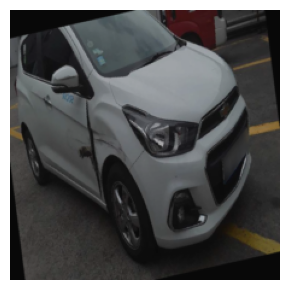

In [11]:
# Take one image from batch (C, H, W):
img = images[0]

# Convert to (H, W, C)
img = img.permute(1, 2, 0)

# Unnormalize
mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])

img = img * std + mean

# Clip to valid range
img = img.clamp(0, 1)

# Plot
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()


<h3 style = "color:blue" >Modelling</h3>

### 1. CNN

In [12]:
class DamageDetectorCNN(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(in_channels= 3, out_channels= 16, kernel_size=(3,3),stride= 1, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),

            nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size=(3,3), stride= 1, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= (2,2), stride= 2, padding= 0),

            nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size=(3,3), stride= 1, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= (2,2), stride= 2, padding= 0),

            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
       
        )

    def forward(self, x):
        x = self.network(x)
        return x


In [13]:
#Instantiate the model, Loss function, and optimizer
model = DamageDetectorCNN(num_classes= 6).to(device= device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params= model.parameters(), lr= 0.001)

In [14]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        #Training
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1} - Epoch: {epoch+1} - Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {epoch_loss:.4f}")


        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels, all_predictions = [], []

        with torch.inference_mode():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [15]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs= 10)

Batch: 10 - Epoch: 1 - Loss: 1.80
Batch: 20 - Epoch: 1 - Loss: 1.79
Batch: 30 - Epoch: 1 - Loss: 1.83
Batch: 40 - Epoch: 1 - Loss: 1.67
Batch: 50 - Epoch: 1 - Loss: 1.38
Epoch [1/10] - Avg Loss: 1.8187
*** Validation Accuracy: 39.83% ***
Batch: 10 - Epoch: 2 - Loss: 1.53
Batch: 20 - Epoch: 2 - Loss: 1.37
Batch: 30 - Epoch: 2 - Loss: 1.55
Batch: 40 - Epoch: 2 - Loss: 1.12
Batch: 50 - Epoch: 2 - Loss: 1.05
Epoch [2/10] - Avg Loss: 1.3234
*** Validation Accuracy: 49.39% ***
Batch: 10 - Epoch: 3 - Loss: 1.20
Batch: 20 - Epoch: 3 - Loss: 1.02
Batch: 30 - Epoch: 3 - Loss: 0.96
Batch: 40 - Epoch: 3 - Loss: 1.32
Batch: 50 - Epoch: 3 - Loss: 1.16
Epoch [3/10] - Avg Loss: 1.1538
*** Validation Accuracy: 57.04% ***
Batch: 10 - Epoch: 4 - Loss: 0.99
Batch: 20 - Epoch: 4 - Loss: 0.75
Batch: 30 - Epoch: 4 - Loss: 1.10
Batch: 40 - Epoch: 4 - Loss: 1.02
Batch: 50 - Epoch: 4 - Loss: 1.02
Epoch [4/10] - Avg Loss: 1.0034
*** Validation Accuracy: 56.17% ***
Batch: 10 - Epoch: 5 - Loss: 1.22
Batch: 20 - Ep

### 2. CNN with Regularization

In [16]:
class DamageDetectorCNN(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(in_channels= 3, out_channels= 16, kernel_size=(3,3),stride= 1, padding= 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),

            nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size=(3,3), stride= 1, padding= 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= (2,2), stride= 2, padding= 0),

            nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size=(3,3), stride= 1, padding= 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= (2,2), stride= 2, padding= 0),

            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, num_classes)
       
        )

    def forward(self, x):
        x = self.network(x)
        return x


In [17]:
model = DamageDetectorCNN(num_classes=6).to(device= device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params= model.parameters(), lr= 0.001, weight_decay= 1e-4)

In [18]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs= 10)

Batch: 10 - Epoch: 1 - Loss: 14.93
Batch: 20 - Epoch: 1 - Loss: 4.61
Batch: 30 - Epoch: 1 - Loss: 1.68
Batch: 40 - Epoch: 1 - Loss: 1.53
Batch: 50 - Epoch: 1 - Loss: 1.65
Epoch [1/10] - Avg Loss: 7.3813
*** Validation Accuracy: 34.78% ***
Batch: 10 - Epoch: 2 - Loss: 1.42
Batch: 20 - Epoch: 2 - Loss: 1.55
Batch: 30 - Epoch: 2 - Loss: 1.54
Batch: 40 - Epoch: 2 - Loss: 1.58
Batch: 50 - Epoch: 2 - Loss: 1.46
Epoch [2/10] - Avg Loss: 1.5177
*** Validation Accuracy: 50.78% ***
Batch: 10 - Epoch: 3 - Loss: 1.48
Batch: 20 - Epoch: 3 - Loss: 1.60
Batch: 30 - Epoch: 3 - Loss: 1.67
Batch: 40 - Epoch: 3 - Loss: 1.40
Batch: 50 - Epoch: 3 - Loss: 1.39
Epoch [3/10] - Avg Loss: 1.3930
*** Validation Accuracy: 49.91% ***
Batch: 10 - Epoch: 4 - Loss: 1.29
Batch: 20 - Epoch: 4 - Loss: 1.27
Batch: 30 - Epoch: 4 - Loss: 1.34
Batch: 40 - Epoch: 4 - Loss: 1.08
Batch: 50 - Epoch: 4 - Loss: 1.49
Epoch [4/10] - Avg Loss: 1.3030
*** Validation Accuracy: 47.65% ***
Batch: 10 - Epoch: 5 - Loss: 1.32
Batch: 20 - E

### 3. Transfer Learning implementation with EfficientNet

In [19]:
class DamageDetectionEN(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights = "DEFAULT")

        #Freeze all layers except the final fully connected layer
        for params in self.model.parameters():
            params.requires_grad = False

        in_features = self.model.classifier[1].in_features 

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [20]:
model = DamageDetectionEN(num_classes= 6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda x: x.requires_grad, model.parameters()), lr= 0.001)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\sugan/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 50.4MB/s]


In [21]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs= 10)

Batch: 10 - Epoch: 1 - Loss: 1.62
Batch: 20 - Epoch: 1 - Loss: 1.66
Batch: 30 - Epoch: 1 - Loss: 1.49
Batch: 40 - Epoch: 1 - Loss: 1.31
Batch: 50 - Epoch: 1 - Loss: 1.27
Epoch [1/10] - Avg Loss: 1.4721
*** Validation Accuracy: 62.96% ***
Batch: 10 - Epoch: 2 - Loss: 1.27
Batch: 20 - Epoch: 2 - Loss: 1.37
Batch: 30 - Epoch: 2 - Loss: 1.20
Batch: 40 - Epoch: 2 - Loss: 1.12
Batch: 50 - Epoch: 2 - Loss: 1.09
Epoch [2/10] - Avg Loss: 1.1550
*** Validation Accuracy: 65.57% ***
Batch: 10 - Epoch: 3 - Loss: 0.96
Batch: 20 - Epoch: 3 - Loss: 1.14
Batch: 30 - Epoch: 3 - Loss: 0.78
Batch: 40 - Epoch: 3 - Loss: 0.99
Batch: 50 - Epoch: 3 - Loss: 0.84
Epoch [3/10] - Avg Loss: 1.0348
*** Validation Accuracy: 68.35% ***
Batch: 10 - Epoch: 4 - Loss: 1.04
Batch: 20 - Epoch: 4 - Loss: 0.93
Batch: 30 - Epoch: 4 - Loss: 1.02
Batch: 40 - Epoch: 4 - Loss: 1.27
Batch: 50 - Epoch: 4 - Loss: 1.06
Epoch [4/10] - Avg Loss: 0.9788
*** Validation Accuracy: 68.17% ***
Batch: 10 - Epoch: 5 - Loss: 0.74
Batch: 20 - Ep

### 4. Transfer Learning implementation with ResNet

In [22]:
class DamageDetectionResNet(nn.Module):
    
    def __init__(self, num_classes, dropout_rate):
        super().__init__()
        self.model = models.resnet50(weights = "DEFAULT")

        #Freeze all layers except the final fully connected layer
        for params in self.model.parameters():
            params.requires_grad = False


        #Unfreeze Layer4 and FC Layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        #Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [24]:
model = DamageDetectionResNet(num_classes= 6,dropout_rate= 0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda x:x.requires_grad, model.parameters()), lr= 0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\sugan/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 61.9MB/s]


In [25]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs= 10)

Batch: 10 - Epoch: 1 - Loss: 1.24
Batch: 20 - Epoch: 1 - Loss: 0.65
Batch: 30 - Epoch: 1 - Loss: 0.69
Batch: 40 - Epoch: 1 - Loss: 0.81
Batch: 50 - Epoch: 1 - Loss: 0.67
Epoch [1/10] - Avg Loss: 0.8922
*** Validation Accuracy: 76.87% ***
Batch: 10 - Epoch: 2 - Loss: 0.66
Batch: 20 - Epoch: 2 - Loss: 0.20
Batch: 30 - Epoch: 2 - Loss: 0.51
Batch: 40 - Epoch: 2 - Loss: 0.66
Batch: 50 - Epoch: 2 - Loss: 0.33
Epoch [2/10] - Avg Loss: 0.4839
*** Validation Accuracy: 76.70% ***
Batch: 10 - Epoch: 3 - Loss: 0.34
Batch: 20 - Epoch: 3 - Loss: 0.46
Batch: 30 - Epoch: 3 - Loss: 0.35
Batch: 40 - Epoch: 3 - Loss: 0.28
Batch: 50 - Epoch: 3 - Loss: 0.36
Epoch [3/10] - Avg Loss: 0.3526
*** Validation Accuracy: 75.30% ***
Batch: 10 - Epoch: 4 - Loss: 0.18
Batch: 20 - Epoch: 4 - Loss: 0.23
Batch: 30 - Epoch: 4 - Loss: 0.20
Batch: 40 - Epoch: 4 - Loss: 0.37
Batch: 50 - Epoch: 4 - Loss: 0.21
Epoch [4/10] - Avg Loss: 0.2897
*** Validation Accuracy: 80.87% ***
Batch: 10 - Epoch: 5 - Loss: 0.15
Batch: 20 - Ep

I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are:
- Dropout rate = 0.3
- Learning rate = 0.0005

In [26]:
model = DamageDetectionResNet(num_classes= 6, dropout_rate= 0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda x:x.requires_grad, model.parameters()), lr= 0.0005)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs= 10)

Batch: 10 - Epoch: 1 - Loss: 1.42
Batch: 20 - Epoch: 1 - Loss: 0.87
Batch: 30 - Epoch: 1 - Loss: 0.59
Batch: 40 - Epoch: 1 - Loss: 0.72
Batch: 50 - Epoch: 1 - Loss: 0.51
Epoch [1/10] - Avg Loss: 0.9363
*** Validation Accuracy: 78.26% ***
Batch: 10 - Epoch: 2 - Loss: 0.45
Batch: 20 - Epoch: 2 - Loss: 0.39
Batch: 30 - Epoch: 2 - Loss: 0.58
Batch: 40 - Epoch: 2 - Loss: 0.54
Batch: 50 - Epoch: 2 - Loss: 0.67
Epoch [2/10] - Avg Loss: 0.4776
*** Validation Accuracy: 76.35% ***
Batch: 10 - Epoch: 3 - Loss: 0.18
Batch: 20 - Epoch: 3 - Loss: 0.18
Batch: 30 - Epoch: 3 - Loss: 0.36
Batch: 40 - Epoch: 3 - Loss: 0.19
Batch: 50 - Epoch: 3 - Loss: 0.24
Epoch [3/10] - Avg Loss: 0.3116
*** Validation Accuracy: 80.52% ***
Batch: 10 - Epoch: 4 - Loss: 0.22
Batch: 20 - Epoch: 4 - Loss: 0.18
Batch: 30 - Epoch: 4 - Loss: 0.27
Batch: 40 - Epoch: 4 - Loss: 0.09
Batch: 50 - Epoch: 4 - Loss: 0.14
Epoch [4/10] - Avg Loss: 0.2253
*** Validation Accuracy: 78.09% ***
Batch: 10 - Epoch: 5 - Loss: 0.31
Batch: 20 - Ep

<h3 style = "color:blue" >Model Evaluation using Confusion Matrix and Classification Report</h3>

In [27]:
report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.93      0.89       134
           1       0.79      0.74      0.76        89
           2       0.94      0.88      0.91       143
           3       0.72      0.73      0.72        73
           4       0.56      0.65      0.60        66
           5       0.79      0.66      0.72        70

    accuracy                           0.80       575
   macro avg       0.77      0.77      0.77       575
weighted avg       0.80      0.80      0.80       575



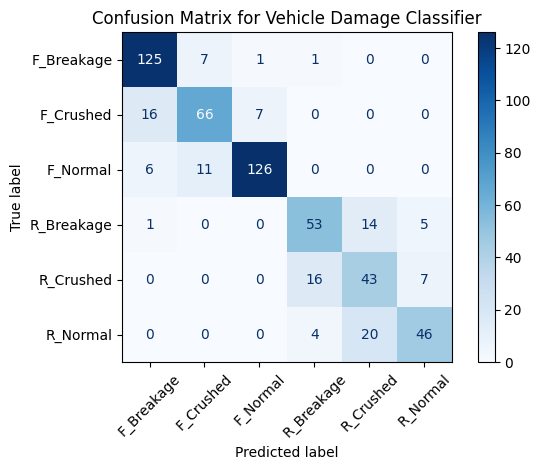

In [28]:

conf_matrix = confusion_matrix(all_labels, all_predictions, labels= np.arange(6))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels= class_names)
disp.plot(cmap= plt.cm.Blues, xticks_rotation= 45)
plt.title("Confusion Matrix for Vehicle Damage Classifier")
plt.tight_layout()
plt.show();

In [30]:
torch.save(model.state_dict(), 'model.pth' )